In [1]:
from __future__ import print_function
from __future__ import division
from keras.utils import plot_model
from keras.optimizers import Adam
from keras.models import Sequential, model_from_json
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, LSTM, Embedding, Dropout, GRU
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split

from lib.pretty_testing import predict_test, class_weights_max
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

Using TensorFlow backend.


In [2]:
top_words = 5000
embedding_vector_length = 32
maxlen = 100
epochs = 30
classes = ['poteri', 'scadenza', 'assemblea', 'clausola', 'non_riconducibile']

In [3]:
# load prepared data
with open('../extraction/dataset.p') as f:
    data, labels = pickle.load(f)

In [4]:
padded_data = sequence.pad_sequences(data, maxlen, padding="pre", truncating="post", value=0, dtype='uint32')
labels = np.array(labels)

In [5]:
model = Sequential()
model.add(Embedding(top_words, embedding_vector_length, input_length=maxlen, mask_zero=True))
model.add(LSTM(32, dropout=0.2)) #return_sequences=True
model.add(Dense(len(classes), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 168,485
Trainable params: 168,485
Non-trainable params: 0
_________________________________________________________________


In [6]:
plot_model(model, to_file='model.png')

In [7]:
X_train, X_test, y_train, y_test = train_test_split(padded_data, labels, train_size=0.8, stratify=labels)
y_train_cat = to_categorical(y_train, num_classes=len(classes))
y_test_cat = to_categorical(y_test, num_classes=len(classes))

/usr/local/lib/python2.7/dist-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
[l.get_weights()[0].shape for l in model.layers]

[(5000, 32), (32, 128), (32, 5)]

In [9]:
class_weights = class_weights_max(labels)

In [10]:
class_weights

{0: 4.360730593607306,
 1: 136.42857142857142,
 2: 7.958333333333333,
 3: 5.520231213872832,
 4: 1.0}

In [11]:
h = model.fit(X_train,  y_train_cat, epochs=epochs, batch_size=32, verbose=0, class_weight=class_weights)
#h.history

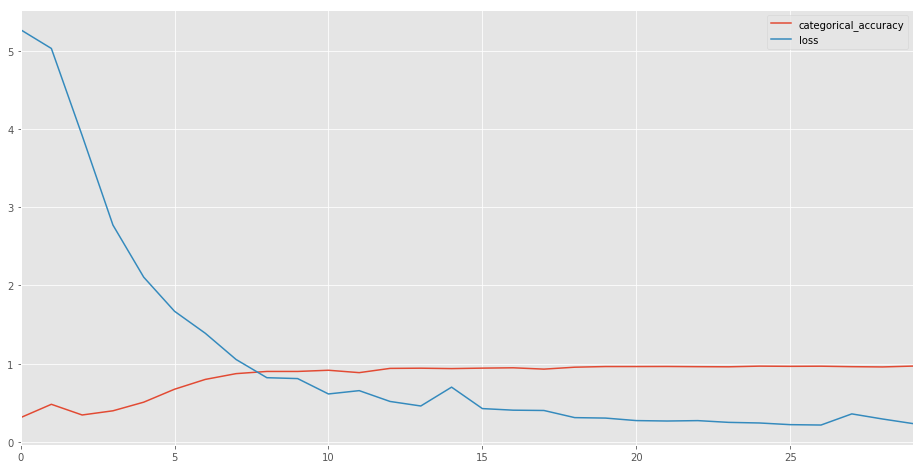

In [12]:
df = pd.DataFrame(h.history)
df.plot(figsize=(16,8))

In [13]:
predict_test(model, X_test, y_test, classes)

()
Test classification report
Accuracy: 0.738983
             precision    recall  f1-score   support

          0       0.69      0.57      0.62        44
          1       0.25      1.00      0.40         1
          2       0.50      0.71      0.59        24
          3       0.66      0.71      0.68        35
          4       0.82      0.79      0.80       191

avg / total       0.75      0.74      0.74       295

Test confusion Matrix
                                 poteri          scadenza         assemblea          clausola non_riconducibile
               poteri              25.0               1.0               1.0               0.0              17.0
             scadenza               0.0               1.0               0.0               0.0               0.0
            assemblea               0.0               0.0              17.0               0.0               7.0
             clausola               0.0               0.0               1.0              25.0              

0.73898305084745763